## COVID-19 country comparison

In [458]:
import requests
import pandas as pd
from io import StringIO
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display
import datetime
import math

data_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/" +\
           "csse_covid_19_time_series/time_series_19-covid-Confirmed.csv"

def set_y_axis_format(log=True):
    if log:
        plt.yscale("log")
    plt.gca().get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: f"{x:,.0f}"))

### Retrieve the latest version of the data and transform it into a Pandas dataframe

Show the first few rows of the dataframe for illustration

In [366]:
r = requests.get(data_url)
s = StringIO(r.text)
df = pd.read_csv(s, sep=",")

with pd.option_context("display.max_rows", 5, "display.max_columns", 15):
    display(df)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,...,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20
0,Anhui,Mainland China,31.8257,117.2264,1,9,15,...,990,990,990,990,990,990,990
1,Beijing,Mainland China,40.1824,116.4142,14,22,36,...,413,414,414,418,418,422,426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,"Tulsa County, OK",US,36.1593,-95.9410,0,0,0,...,0,0,0,0,0,0,1
224,"Montgomery County, TX",US,30.3213,-95.4778,0,0,0,...,0,0,0,0,0,0,0


### Add up all provinces/states into one row per country 

In [420]:
by_country = df.groupby("Country/Region").sum()                           # Group by country
dates = by_country.columns[2:]                                            # Drop Lat/Long columns
by_country.loc["Outside China", dates] =\
    by_country.sum().loc[dates]-by_country.loc["Mainland China", dates]   # Add "Outside China" row
by_country = by_country.loc[:, dates].astype(int)                         # Convert to integers
with pd.option_context("display.max_rows", 5, "display.max_columns", 15):
    display(by_country)

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,...,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20
Country/Region,,,,,,,,,,,,,,,
Afghanistan,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1
Algeria,0,0,0,0,0,0,0,...,1,3,5,12,12,17,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vietnam,0,2,2,2,2,2,2,...,16,16,16,16,16,16,18
Outside China,8,14,25,35,56,64,84,...,8545,10283,12692,14852,17463,21226,25184


### List all countries in the `by_country` table

In [421]:
for i, k in enumerate(by_country.index):
    if len(k) > 15:
        k = k[:15] + "."
    print(f"{k:17}", end=" " if (i+1) % 7 else "\n")

Afghanistan       Algeria           Andorra           Argentina         Armenia           Australia         Austria          
Azerbaijan        Bahrain           Belarus           Belgium           Bhutan            Bosnia and Herz.  Brazil           
Cambodia          Cameroon          Canada            Chile             Colombia          Costa Rica        Croatia          
Czech Republic    Denmark           Dominican Repub.  Ecuador           Egypt             Estonia           Faroe Islands    
Finland           France            French Guiana     Georgia           Germany           Gibraltar         Greece           
Hong Kong         Hungary           Iceland           India             Indonesia         Iran              Iraq             
Ireland           Israel            Italy             Japan             Jordan            Kuwait            Latvia           
Lebanon           Liechtenstein     Lithuania         Luxembourg        Macau             Mainland China    Malaysia  

### Plot cases over calendar date in several time

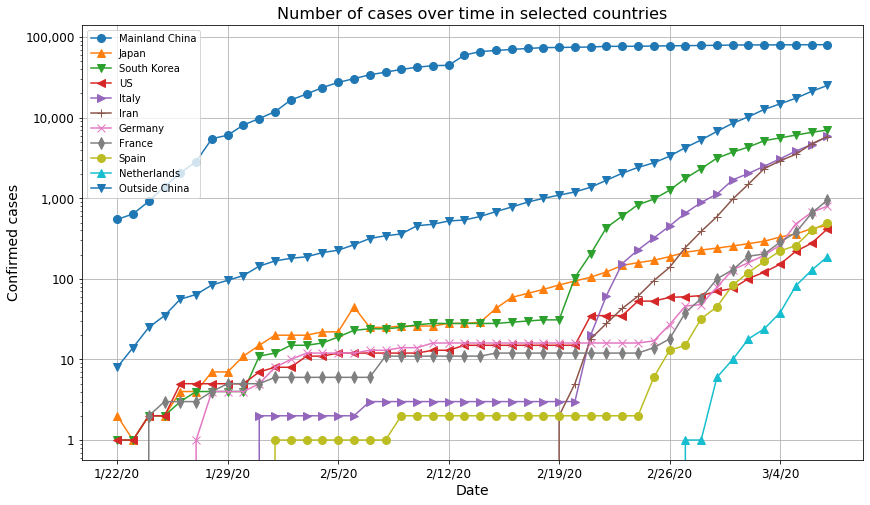

In [463]:
countries_to_plot = ["Mainland China", "Japan", "South Korea", "US", "Italy", "Iran", "Germany",
                     "France", "Spain", "Netherlands", "Outside China"]
markers = "o^v<>+xd"
m = len(markers)

plt.figure(figsize=(14,8))
for i, country in enumerate(countries_to_plot):
    plt.plot(by_country.loc[country, dates], markers[i%m]+"-", label=country, markersize=8)
    
plt.legend()
plt.xlabel("Date", fontsize=14)
plt.ylabel("Confirmed cases", fontsize=14)
set_y_axis_format()
plt.grid()
locs, labels = plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(locs[::7], dates[::7])
plt.title("Number of cases over time in selected countries", fontsize=16)
plt.show()

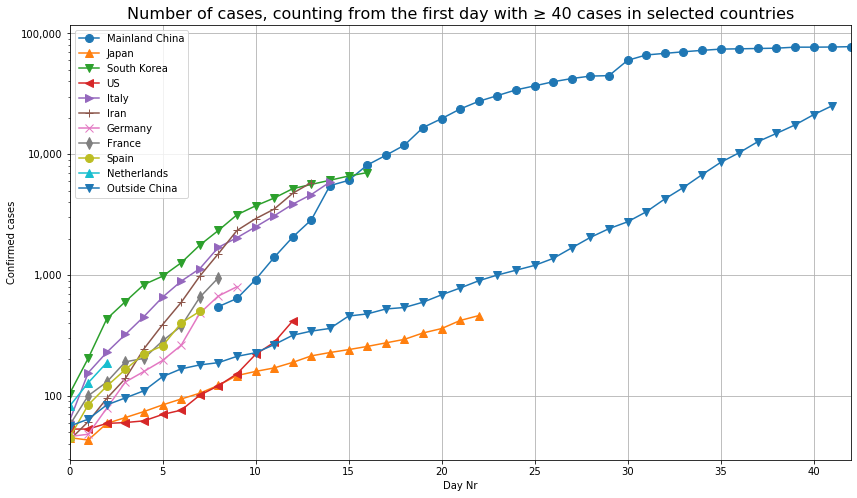

In [466]:
min_cases = 40
length = None

plt.figure(figsize=(14,8))
for i, country in enumerate(countries_to_plot):
    country_data = by_country.loc[country, dates]
    country_data = country_data[country_data >= min_cases]
    if country == "Outside China":
        length = len(country_data)
    day_nr = list(range(len(country_data)))
    if country == "Mainland China":
        day_nr = [x + 8 for x in day_nr]  # offset for China since the data start with >1000 cases already
    plt.plot(day_nr, country_data, markers[i%m]+"-", label=country, markersize=8)
    
plt.legend()
plt.xlabel("Day Nr")
plt.xlim(0, length)
plt.ylabel("Confirmed cases")
plt.grid()
locs, labels = plt.xticks()
set_y_axis_format()
plt.gca().get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: f"{x:,.0f}"))
plt.title(f"Number of cases, counting from the first day with ≥ {min_cases} cases in selected countries", fontsize=16)
plt.show()

# TODO, same x-axis, 7-day average growth factor on y-axis

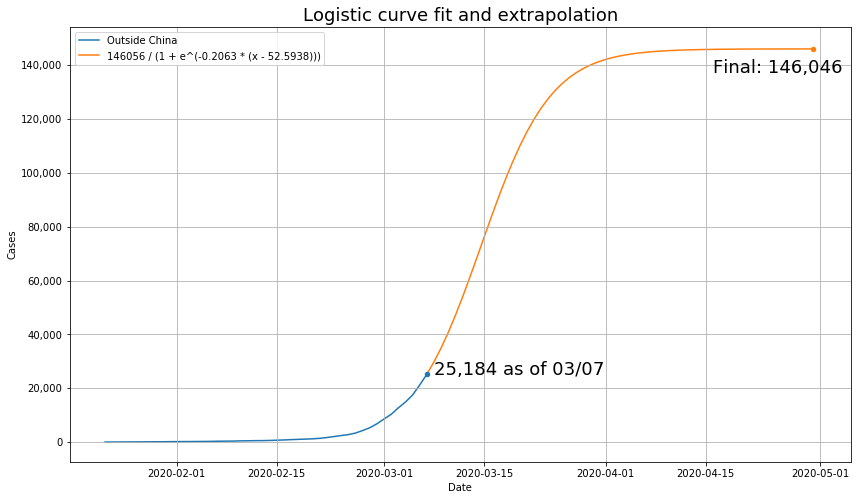

In [459]:
from matplotlib import dates as mdates
from scipy.optimize import curve_fit

x = np.arange(100)
outside_china = by_country.loc["Outside China", :]

def func(x, L, k, x0):
    return L / (1 + np.exp(-k * (x - x0)))

[L, k, x0], _ =  curve_fit(func, np.arange(len(outside_china)), outside_china, p0=[1e7, 0.5, 65])

current_day = datetime.datetime.strptime(dates[-1], "%m/%d/%y")
date_list = [datetime.datetime.strptime(x, "%m/%d/%y") for x in dates]

plt.figure(figsize=(14,8))
plt.plot(date_list, outside_china, label="Outside China", markersize=3, zorder=1)

model_date_list = [current_day + datetime.timedelta(days = n+1) for n in range(-1, len(x) - len(date_list))]
model_date_list = [mdates.date2num(x) for x in model_date_list]

n = len(date_list)
logistic = L / (1 + np.exp(-k*(x[n-1:]-x0)))
plt.plot(model_date_list, logistic, label=f"{L:.0f} / (1 + e^(-{k:.4f} * (x - {x0:.4f})))", zorder=1)

plt.grid()
locs, labels = plt.xticks()

plt.legend()
plt.title("Logistic curve fit and extrapolation", fontsize=18)
plt.xlabel("Date")
plt.ylabel("Cases")
plt.scatter(mdates.date2num(current_day), outside_china[-1], s=20, c="C00", zorder=2)
plt.annotate(f"{outside_china[-1]:,.0f} as of {datetime.datetime.strftime(current_day, '%m/%d')}", 
             (mdates.date2num(current_day)+1, outside_china[-1]), fontsize=18)

plt.scatter(model_date_list[-1], logistic[-1], s=20, c="C01", zorder=2)
plt.annotate(f"Final: {logistic[-1]:,.0f}", (model_date_list[-1]-14, logistic[-1]*0.94), fontsize=18)
set_y_axis_format(False)
plt.show()